In [1]:
from pyscf import gto, scf, mcscf, fci
import numpy as np
import matplotlib.pyplot as plt
from pyblock2._pyscf.ao2mo import integrals as itg
from pyblock2.driver.core import DMRGDriver, SymmetryTypes
import os 

Use this to delete the temp files BEFORE a dmrg calculation

In [18]:
folder_path = "./tmpheh"  #change here the directory where the tmp files are located

for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Check if it's a file (not a directory) and delete it
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Deleted: {file_path}")

Deleted: ./tmpheh/F.MPS.GS.0
Deleted: ./tmpheh/F.MPS.GS.1
Deleted: ./tmpheh/F.MPS.INFO.GS.LEFT.0
Deleted: ./tmpheh/F.MPS.INFO.GS.RIGHT.0
Deleted: ./tmpheh/F.MPS.INFO.GS.LEFT.1
Deleted: ./tmpheh/F.MPS.INFO.GS.RIGHT.1
Deleted: ./tmpheh/F.MPS.INFO.GS.LEFT.2
Deleted: ./tmpheh/F.MPS.INFO.GS.RIGHT.2
Deleted: ./tmpheh/F.MPS.GS.-1
Deleted: ./tmpheh/GS-mps_info.bin


In [10]:
#Helium-hydrogen test test

heh = gto.M(atom=[["He", 0, 0, 0],
                  ["H", 7.0, 0, 0]], unit = 'Bohr', basis = 'sto-3g', charge = 0, spin = 1)
uhf_heh=scf.UHF(heh)
uhf_heh.kernel()

Heh_alpha_mo_en = uhf_heh.mo_energy[0]
Heh_beta_mo_en = uhf_heh.mo_energy[1]
Heh_alpha_mo_coeff = uhf_heh.mo_coeff[0]
Heh_beta_mo_coeff = uhf_heh.mo_coeff[1]
Heh_alpha_occ=uhf_heh.mo_occ[0]
Heh_beta_occ=uhf_heh.mo_occ[1]

print(Heh_alpha_mo_en)
print(Heh_beta_mo_en)
#print(Heh_alpha_occ)
#print(Heh_beta_occ)
print(Heh_alpha_mo_coeff)
print(Heh_beta_mo_coeff)


#np.save('/workspaces/MRA-OrbitalOptimization/Block2/HeH_test/coeffs/120_alphacoeffs.npy', Heh_alpha_mo_coeff)
#np.save('/workspaces/MRA-OrbitalOptimization/Block2/HeH_test/coeffs/120_betacoeffs.npy', Heh_beta_mo_coeff)

converged SCF energy = -3.27436495007348  <S^2> = 0.75  2S+1 = 2
[-0.87603774 -0.46657949]
[-0.87603553  0.30802643]
[[ 0.99999738 -0.00248054]
 [ 0.0015241   0.9999993 ]]
[[ 9.99999348e-01 -1.48923084e-03]
 [ 5.32790413e-04  1.00000032e+00]]


In [4]:
#FCI Referenz
energy_fci = []

for i in np.arange(1.2, 7.1, 0.1):
    Heh_fci = gto.M(atom=[["He", 0, 0, 0],
                        ["H", i, 0, 0]], unit = 'Bohr', basis = 'cc-pvtz', charge = 0, spin = 1)
    uhf_hehfci=scf.UHF(Heh_fci)
    uhf_hehfci.kernel()
    fcisolver = fci.FCI(uhf_hehfci)
    energy_fci.append(fcisolver.kernel()[0])


converged SCF energy = -3.13179018978606  <S^2> = 0.75055751  2S+1 = 2.0005574
converged SCF energy = -3.16484302194819  <S^2> = 0.75067565  2S+1 = 2.0006755
converged SCF energy = -3.19216039605144  <S^2> = 0.75078489  2S+1 = 2.0007847
converged SCF energy = -3.21519572472312  <S^2> = 0.75087761  2S+1 = 2.0008774
converged SCF energy = -3.23488097914621  <S^2> = 0.75094658  2S+1 = 2.0009464
converged SCF energy = -3.25184441432973  <S^2> = 0.75098648  2S+1 = 2.0009862
converged SCF energy = -3.26653453099571  <S^2> = 0.75099499  2S+1 = 2.0009947
converged SCF energy = -3.27929077020825  <S^2> = 0.75097334  2S+1 = 2.0009731
converged SCF energy = -3.29038289604833  <S^2> = 0.75092583  2S+1 = 2.0009256
converged SCF energy = -3.30003282294793  <S^2> = 0.75085869  2S+1 = 2.0008585
converged SCF energy = -3.30842720748585  <S^2> = 0.75077878  2S+1 = 2.0007786
converged SCF energy = -3.31572533602107  <S^2> = 0.75069252  2S+1 = 2.0006924
converged SCF energy = -3.32206454674158  <S^2> = 0.

In [15]:
heh = gto.M(atom=[["He", 0, 0, 0],
                  ["H", 1.2, 0, 0]], basis = 'sto-3g', charge = 0, spin = 1)
uhf_heh=scf.UHF(heh)
uhf_heh.kernel()

norbs, nelecas = (2, (2, 1))
ref_ucas = mcscf.UCASSCF(uhf_heh, norbs, nelecas).mc1step()[0]

bond_dims = [250] * 8
noises = [1e-4] * 4 + [1e-5] * 4 + [0]
thrds = [1e-10] * 8
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_uhf_integrals(uhf_heh,
    ncore=0, ncas=None, g2e_symm=1)


driver_631g = DMRGDriver(scratch="./tmpheh", symm_type=SymmetryTypes.SZ, n_threads=4)
driver_631g.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo_631g = driver_631g.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=1)
ket_631g = driver_631g.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy_631g = driver_631g.dmrg(mpo_631g, ket_631g, n_sweeps=10, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('DMRG energy = %20.15f' % energy_631g)
print('difference dmrg UCASSCF', ref_ucas - energy_631g)

converged SCF energy = -3.21609329134427  <S^2> = 0.75  2S+1 = 2
UCASSCF energy = -3.21609329134427
UCASCI E = -3.21609329134427  E(CI) = -4.09805530954427  S^2 = 0.7500000
integral symmetrize error =  0.0
integral cutoff error =  0.0
mpo terms =         54

Build MPO | Nsites =     2 | Nterms =         54 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /     2 .. Mmpo =    22 DW = 0.00e+00 NNZ =       22 SPT = 0.0000 Tmvc = 0.000 T = 0.001
 Site =     1 /     2 .. Mmpo =     1 DW = 0.00e+00 NNZ =       22 SPT = 0.0000 Tmvc = 0.000 T = 0.001
Ttotal =      0.003 Tmvc-total = 0.000 MPO bond dimension =    22 MaxDW = 0.00e+00
NNZ =           44 SIZE =           44 SPT = 0.0000



Rank =     0 Ttotal =      0.007 MPO method = FastBipartite bond dimension =      22 NNZ =           44 SIZE =           44 SPT = 0.0000

Sweep =    0 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.025 | E =      -3.2160932913 | DW = 0.00000e+00

Sweep =    1 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.048 | E =      -3.2160932913 | DE = 0.00e+00 | DW = 0.00000e+00

Sweep =    2 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.073 | E =      -3.2160932913 | DE = 0.00e+00 | DW = 0.00000e+00

Sweep =    3 | Direction = backward | Bond dimension =  250 | Noise =  1.00e-04 | Dav threshold =  1.00e-10
Time elapsed =      0.099 | E =      -3.2160932913 | DE = 0.00e+00 | DW = 0.00000e+00

Sweep =    4 | Direction =  forward | Bond dimension =  250 | Noise =  1.00e-05 | Dav threshold = 

In [2]:
heh = gto.M(atom=[["He", 0, 0, 0],
                  ["H", 1.0, 0, 0]], basis = 'sto-3g', charge = 0, spin = 1)
uhf_heh=scf.UHF(heh)
uhf_heh.kernel()

Heh_alpha_mo_coeff = uhf_heh.mo_coeff[0]
Heh_beta_mo_coeff = uhf_heh.mo_coeff[1]

print(Heh_alpha_mo_coeff)
print(Heh_beta_mo_coeff)



converged SCF energy = -3.1578592138  <S^2> = 0.75  2S+1 = 2
[[ 0.89817854 -0.61217651]
 [ 0.21117883  1.06624963]]
[[ 0.95022939 -0.52777729]
 [ 0.11313171  1.08105781]]


In [2]:
diff = -3.216093291344268 + 3.21607912659261
print(diff)

-1.4164751658274355e-05


Dissociation curve He-H of UHf

In [2]:
Euhf_heh = []



#bond_dims = [50] * 10
#noises = [1e-4] *  5 + [1e-5] * 5 + [0]
#thrds = [1e-10] * 10

for a in np.arange(0.5, 7, 0.1):
    Heh = gto.M(atom=[["He", 0, 0, 0],
                      [ "H", a, 0, 0]], basis = 'sto-3g', charge = 0, spin = 1, unit='Bohr')
    uhf =scf.UHF(Heh)
    Euhf_heh.append(uhf.kernel())
    
    #ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_uhf_integrals(uhf,
    #ncore=0, ncas=None, g2e_symm=8)
    #dmrg_driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
    #dmrg_driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)
    #mpo = dmrg_driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
    #ket = dmrg_driver.get_random_mps(tag="GS", bond_dim=10, nroots=1)
    #energy = dmrg_driver.dmrg(mpo, ket, n_sweeps=15, bond_dims=bond_dims, noises=noises,
    #thrds=thrds, cutoff=0, iprint=0)
    #Edmrg_H2.append(energy)

converged SCF energy = -0.981871090413472  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -1.53194903823921  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -1.9246079234282  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -2.21529359790484  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -2.43524266483413  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -2.60402096752108  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -2.7348427991196  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -2.83711206976519  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -2.91773574934364  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -2.98185893674057  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -3.03332427534888  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -3.07499588737651  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -3.10900679668694  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -3.13695188610578  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -3.16003547080316  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -3.

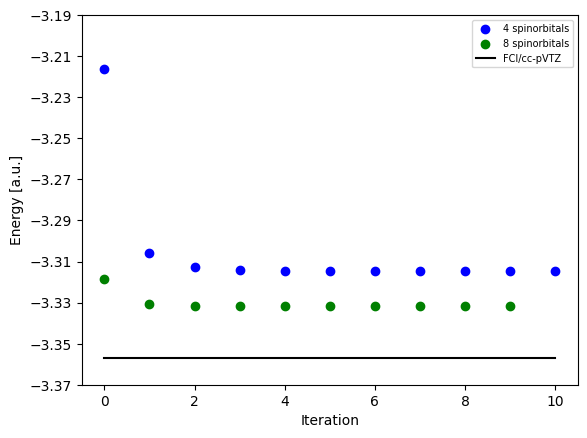

In [25]:
x = np.arange(0, 10, 1)
x2 = np.arange(0, 11, 1)
energy_631g = [-3.318389, -3.330713, -3.331502, -3.331640, -3.331673, -3.331683, -3.331686, -3.331688, -3.331688, -3.331688]
energy_sto3g = [-3.216079, -3.305759, -3.312885, -3.314307, -3.314675, -3.314786, -3.314824, -3.314837, -3.314842, -3.314844, -3.314844]
energy_fci = np.full(11, -3.3570239958160712)

fig, ax = plt.subplots()
#ax.scatter(x, Euhf_heh, color='blue', label='UHF HeH STO-3G')
ax.scatter(x2, energy_sto3g, color='blue', label='4 spinorbitals')
ax.scatter(x, energy_631g, color='green', label='8 spinorbitals')
ax.plot(x2, energy_fci, color='black', label='FCI/cc-pVTZ')
ax.legend(loc='upper right', fontsize=7)

ax.set_xlabel('Iteration')
ax.set_ylabel('Energy [a.u.]')
#ax.set_xticks(np.arange(0.8, 4.4, 0.4))
ax.set_yticks(np.arange(-3.19, -3.37, -0.02))

plt.show()

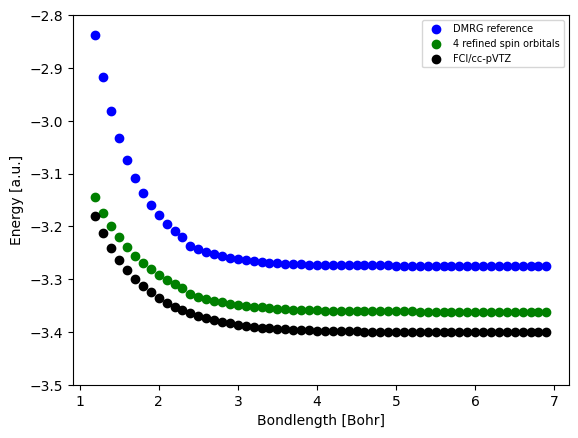

In [6]:
sto3g_init_energy = [-2.837093967040496, -2.9177185346883423, -2.9818421854105552, -3.03330800393587, -3.074980066743456, -3.1089914367914857, -3.136936919129891, -3.1600193450247795,
                     -3.1791648533054473, -3.1950904255520602, -3.20836493788789, -3.2194454001688784, -3.2364414147108027, -3.2429095450965346, -3.248313932543595, -3.252826517860797, 
                     -3.2565901206757664, -3.259724460599358, -3.2623303326484923, -3.264492664008085, -3.2662832072893266, -3.267762670203637, -3.268982140479504, -3.2699855087384284, 
                     -3.270808924688602, -3.2714832519055124, -3.2720341318502975, -3.272483850821257, -3.2728494653132865, -3.2731462809486227, -3.273386589556032, -3.273581194674879, 
                     -3.2737379610955757, -3.273864131339876, -3.2739653839270404, -3.274046439217869, -3.2741111215036653, -3.2741625124232314, -3.2742034053543265, -3.274236470088293, 
                     -3.274262450405211, -3.2742824625635887, -3.2742963538237673, -3.2743093154378213, -3.274319295838079, -3.2743269580530474, -3.274326795825329, -3.274332989045309, 
                     -3.2743376360418472, -3.2743412011911577, -3.2743440008714266, -3.274346194042887, -3.2743478866533406, -3.2743490059493476, -3.2743500087100923, -3.2743508731812385,
                     -3.274351384220274, -3.274351554337618]
sto3g_refined_energy =[-3.144093521539273, -3.1744546427331217, -3.1996077270296923, -3.220976188628213, -3.2394073292582366, -3.2554369521873148, -3.2694331275612303, -3.281674254253601, 
                       -3.292381603634398, -3.3017416239745, -3.309914791421201, -3.3170413052630034, -3.3286370125496125, -3.3333145191198956, -3.3373643683506504, -3.340865312694047, 
                       -3.343884021617482, -3.34648529569259, -3.3487216747361988, -3.3506414564569122, -3.352287028277499, -3.3536947069047818, -3.3548966457099443, -3.3559219418336808,
                       -3.356795240008779, -3.3575378030948757, -3.3581665706558894, -3.358701711727242, -3.359155210981916, -3.3595385116896925, -3.359862542757555, -3.3601364236869378, 
                       -3.360367040252824, -3.3605609825455347, -3.360724451036981, -3.36086180616565, -3.360977264204111, -3.3610749098847004, -3.3611555769649937, -3.361223050613116, 
                       -3.3612795641536763, -3.361325437106495, -3.3613659857393987, -3.3613993517860505, -3.361421010173911, -3.3614455496792846, -3.361466254484854, -3.361483265720863, 
                       -3.3614972454434278, -3.3615090406386914, -3.361518714796306, -3.3615266376695336, -3.361533291576843, -3.361538768179214, -3.3615432011186783, -3.361547122278753, 
                       -3.3615501124712703, -3.361552903651302]
energy_fci.pop()

x = np.arange(1.2, 7.0, 0.1)
x2 = np.arange(1.2, 7.1, 0.1)

fig, ax = plt.subplots()
ax.scatter(x, sto3g_init_energy, color='blue', label='DMRG reference')
ax.scatter(x, sto3g_refined_energy, color='green', label='4 refined spin orbitals')
ax.scatter(x, energy_fci, color='black', label='FCI/cc-pVTZ')

ax.legend(loc='upper right', fontsize=7)

ax.set_xlabel('Bondlength [Bohr]')
ax.set_ylabel('Energy [a.u.]')
#ax.set_xticks(np.arange(0.8, 4.4, 0.4))
ax.set_yticks(np.arange(-2.8, -3.5, -0.1))

plt.show()





